In [1]:
from typing import List, Dict, Any, Optional, Union

import urllib
import pandas as pd
import networkx as nx

from tqdm import tqdm
from time import time
from rdflib import Graph, URIRef, Literal, Namespace, URIRef
from pathlib import Path
from operator import itemgetter
from matplotlib import pyplot as plt
from collections import Counter
from rdflib.namespace import XSD, RDF, RDFS, SKOS

from rdflib.extras.external_graph_libs import *

Visualizing the graph may improve our understanding of the data in the graph. The IReC GitHub repository contains some instructions for visualizing the graph with GraphDB. The `unfeatured_graph.ttl` file probably contains the most appropriate level of information for visualizing our graph. 

In this notebook, we would like to analyse the graph to identify potential concepts. The idea being that they could be added to a manually curated AEC conceptualization. For analysis, we'll use the `featured_graph.ttl` file.

We'll look at some basic graph analysis approaches:
* **Paths** we could be interested in, e.g.;
  * X constitutes Y constitutes Z etc
  
* Finding **central nodes** based, e.g.;
  * which nodes are likely common high-level classes, e.g., materials, systems, etc. (would we want to reweigh phrasese that contain such words?)
  * features that we could consider include the degree (number of edges for a node), betweennes (number of shortest paths that pass through the node), and 'page rank' (importance of node based on importance of related nodes)
      * concept-concept shortest paths may identify related terms, e.g., determine spans that connect the concepts `fire doorset` and `protected corridor`
      * betweennes centrality may suggest high level concepts, e.g., `materials`, `systems` and so on
      * page rank; which spans are connected to the most influential spans (ones with high betweennes or connected direclty to concepts)
* **Community detection**; find groups of closely connected nodes, e.g., we'd like to find all nodes that are directly related to spans revolving around materials. Approaches to use include Label propagation and Unfolding (Louvain) to compute a bottom-up grouping of connected nodes.

To do:
* continue exploring SPARQL + networkX combinations
  * weighted graph?
* wikiClassLabel; turn into an edge with a span as its representation 
check out how to create useful aggregate queries in SPARQL
* For now, we'll avoid looking at pattern matching through worst case optimal join (WCOJ) algorithms.

In [2]:
graph_output_fp = Path.cwd().joinpath("data", "graph_output")

In [3]:
IREC_spans_URL = "https://spans.irec.org/"
IREC_concepts_URL = "https://concepts.irec.org/"

### Load Graph

In [4]:
irec_graph = Graph()
graph_data_fp = Path.cwd().joinpath("data", "graph_data")
irec_graph.parse(graph_data_fp.joinpath("IREC.rdf"))

<Graph identifier=Na1e101fa23ad4921941ae690840c2c92 (<class 'rdflib.graph.Graph'>)>

In [5]:
# irec_graph.parse(graph_output_fp.joinpath("unfeatured_graph.ttl"))
# unfeatured_nx_graph = rdflib_to_networkx_graph(irec_graph)

In [6]:
# convert to NetworkX graph
irec_graph.parse(graph_output_fp.joinpath("featured_graph.ttl")) 
featured_nx_graph = rdflib_to_networkx_graph(irec_graph)
# G = rdflib_to_networkx_digraph(irec_graph)

### Counting concepts and their definitions

* First, we want to know which concepts have a definition
  * grab UIDs for concepts that have a definition
  * grab the labels (text) for concets with definitions

In [7]:
definitions_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>


SELECT DISTINCT ?nodeUID ?label ?definition WHERE {  
        ?nodeUID a skos:Concept ;
                 skos:prefLabel ?label ;
                 skos:definition|^skos:exactMatch/irec:wikiDefinition ?definition .
        
        VALUES (?definition) {(UNDEF)} 
} GROUP BY ?nodeUID

"""
sparql_result = irec_graph.query(definitions_query)

In [8]:
concepts_with_definitions = {}
for r in sparql_result:
    concept_node = r['nodeUID'] 
    if concept_node not in concepts_with_definitions:
        concepts_with_definitions[concept_node] = [r['definition']]
    else:
        concepts_with_definitions[concept_node].append(r['definition'])

In [9]:
len(concepts_with_definitions)

1432

In [10]:
concept_labels_with_definitions = {}
for r in sparql_result:
    concept_node = r['label'] 
    if concept_node not in concept_labels_with_definitions:
        concept_labels_with_definitions[concept_node] = [r['definition']]
    else:
        concept_labels_with_definitions[concept_node].append(r['definition'])

In [11]:
len(concept_labels_with_definitions)

962

In [12]:
Counter({k: len(v) for k, v in concept_labels_with_definitions.items()}).most_common()

[(rdflib.term.Literal('house', lang='en'), 63),
 (rdflib.term.Literal('Woodlands', lang='en'), 58),
 (rdflib.term.Literal('residential building', lang='en'), 51),
 (rdflib.term.Literal('Chimneys', lang='en'), 10),
 (rdflib.term.Literal('Springs', lang='en'), 6),
 (rdflib.term.Literal('frequency', lang='en'), 5),
 (rdflib.term.Literal('gallery', lang='en'), 5),
 (rdflib.term.Literal('span', lang='en'), 5),
 (rdflib.term.Literal('Trees', lang='en'), 5),
 (rdflib.term.Literal('extension', lang='en'), 5),
 (rdflib.term.Literal('platform', lang='en'), 5),
 (rdflib.term.Literal('landing', lang='en'), 4),
 (rdflib.term.Literal('pier', lang='en'), 4),
 (rdflib.term.Literal('building', lang='en'), 4),
 (rdflib.term.Literal('Pathways', lang='en'), 4),
 (rdflib.term.Literal('enclosure', lang='en'), 4),
 (rdflib.term.Literal('wall', lang='en'), 4),
 (rdflib.term.Literal('block', lang='en'), 4),
 (rdflib.term.Literal('kitchen', lang='en'), 3),
 (rdflib.term.Literal('level', lang='en'), 3),
 (rdflib

* next check overall nr of concepts in graph

In [13]:
unique_concepts_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>

SELECT DISTINCT ?nodeUID ?label WHERE {  
        ?nodeUID a skos:Concept ;
                 skos:prefLabel ?label .
        VALUES (?label) {(UNDEF)}
} GROUP BY ?nodeUID ?label

"""
sparql_result = irec_graph.query(unique_concepts_query)

In [14]:
concepts = {}
for r in sparql_result:
    concept_node = r['nodeUID'] 
    if concept_node not in concepts:
        concepts[concept_node] = [r['label']]
    else:
        concepts[concept_node].append(r['label'])

In [15]:
concept_cnt = Counter({str(k): len(v) for k, v in concepts.items()})
len(concept_cnt)

2034

In [16]:
# not taking into account alternative labels
concept_labels = {}
for r in sparql_result:
    concept_node = r['label'] 
    if concept_node not in concept_labels:
        concept_labels[concept_node] = [r['nodeUID']]
    else:
        concept_labels[concept_node].append(r['nodeUID'])

In [17]:
concept_label_cnt = Counter({str(k): len(v) for k, v in concept_labels.items()})
len(concept_label_cnt)

1539

In [18]:
x = [1,2,3,4]
any([v for v in x if v == 5])

False

In [19]:
# nr Merged Approved documents
print("number of nodes: ", len([k for k, v in concepts.items() if "irec" in k]))
print("number of labels: ", len([k for k, v in concept_labels.items() if any([n for n in v if "irec" in n])]))

number of nodes:  295
number of labels:  295


In [20]:
# nr uniclass, expecting 598 nodes ~ less labels mean some unique UID nodes have the same label
print("number of nodes: ", len([k for k, v in concepts.items() if "uniclass" in k]))
print("number of labels: ", len([k for k, v in concept_labels.items() if any([n for n in v if "uniclass" in n])]))

number of nodes:  598
number of labels:  580


In [21]:
# nr wiki ~ less labels mean some unique UID nodes have the same label
print("number of nodes: ", len([k for k, v in concepts.items() if "wiki" in k]))
print("number of labels: ", len([k for k, v in concept_labels.items() if any([n for n in v if "wiki" in n])]))

number of nodes:  1141
number of labels:  739


In [22]:
# any overlap? 
irec_keys = [k for k in concepts if "irec" in k]
unic_keys = [k for k in concepts if "uniclass" in k]
wiki_keys = [k for k in concepts if "wiki" in k]

In [23]:
def check_overlap(keys_one, keys_two, concepts=concepts):
    overlap = []
    for k1 in keys_one:
        for k2 in keys_two:
            for label in concepts[k1]:
                if label in concepts[k2]:
                    overlap.append(label)
    return overlap

In [24]:
print("irec <--> wiki (overlap unique)", len(list(set(check_overlap(irec_keys, wiki_keys)))), len(check_overlap(irec_keys, wiki_keys)))
print("irec <--> uniclass:", len(list(set(check_overlap(irec_keys, unic_keys)))), len(check_overlap(irec_keys, unic_keys)))
print("uniclass <--> wiki:", len(list(set(check_overlap(unic_keys, wiki_keys)))), len(check_overlap(unic_keys, wiki_keys)))

irec <--> wiki (overlap unique) 61 89
irec <--> uniclass: 0 0
uniclass <--> wiki: 14 96


* what are the concepts without definitions?

In [25]:
print("Nr of defined concepts: ", len(concepts_with_definitions))
print("Nr of defined MAD nodes: ", len([k for k in concepts_with_definitions if "irec" in k]))
print("Nr of defined UNICLASS nodes: ", len([k for k in concepts_with_definitions if "uniclass" in k]))
print("Nr of defined WIKI nodes: ", len([k for k in concepts_with_definitions if "wiki" in k]))

Nr of defined concepts:  1432
Nr of defined MAD nodes:  295
Nr of defined UNICLASS nodes:  31
Nr of defined WIKI nodes:  1106


In [26]:
concept_labels_without_definitions = {}
for r in sparql_result:
    concept_node = r['label'] 
    if concept_node not in concept_labels_without_definitions:
        concept_labels_without_definitions[concept_node] = [r['nodeUID']]
    else:
        concept_labels_without_definitions[concept_node].append(r['nodeUID'])

In [27]:
undefined_concepts_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>


SELECT DISTINCT ?nodeUID ?label WHERE {  
        ?nodeUID a skos:Concept ;
                 skos:prefLabel ?label .
                 
    FILTER NOT EXISTS {?nodeUID skos:definition|^skos:exactMatch/irec:wikiDefinition ?definition .}
} GROUP BY ?nodeUID ?label

"""
sparql_result = irec_graph.query(undefined_concepts_query)

In [28]:
concepts_without_definitions = {}
for r in sparql_result:
    concept_node = r['nodeUID'] 
    if concept_node not in concepts_without_definitions:
        concepts_without_definitions[concept_node] = [r['label']]
    else:
        concepts_without_definitions[concept_node].append(r['label'])

In [29]:
print("Nr of undefined concepts: ", len(concepts_without_definitions))
print("Nr of undefined MAD nodes: ", len([k for k in concepts_without_definitions if "irec" in k]))
print("Nr of undefined UNICLASS nodes: ", len([k for k in concepts_without_definitions if "uniclass" in k]))
print("Nr of undefined WIKI nodes: ", len([k for k in concepts_without_definitions if "wiki" in k]))

Nr of undefined concepts:  602
Nr of undefined MAD nodes:  0
Nr of undefined UNICLASS nodes:  567
Nr of undefined WIKI nodes:  35


In [30]:
concept_labels_without_definitions = {}
for r in sparql_result:
    concept_node = r['label'] 
    if concept_node not in concept_labels_without_definitions:
        concept_labels_without_definitions[concept_node] = [r['nodeUID']]
    else:
        concept_labels_without_definitions[concept_node].append(r['nodeUID'])

In [32]:
undefined_concept_cnt = Counter({str(k): len(v) for k, v in concept_labels_without_definitions.items()})
len(undefined_concept_cnt)

584

In [36]:
# concept where one label has a definition, and another doesn't
defined_and_not_defined = [str(label) for label in concept_labels_with_definitions if label in concept_labels_without_definitions]
print(len(defined_and_not_defined))
print(defined_and_not_defined)

7
['floating floor', 'low voltage', 'sound reduction index', 'wheelchair accessible', 'building work', 'dead load', 'domestic hot water']


In [38]:
# how many altLabels overlap?
altlabel_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>

SELECT DISTINCT ?nodeUID ?label WHERE {  
        ?nodeUID a skos:Concept ;
                 skos:altLabel ?label .
        VALUES (?label) {(UNDEF)}
} GROUP BY ?nodeUID ?label

"""
sparql_result = irec_graph.query(altlabel_query)

In [39]:
altlabels = {}
for r in sparql_result:
    altlabel = r['label'] 
    if altlabel not in altlabels:
        altlabels[altlabel] = [r['nodeUID']]
    else:
        altlabels[altlabel].append(r['nodeUID'])

In [41]:
len(altlabels)

55

In [45]:
altlabels_with_corresponding_concept_node = [k for k in concept_labels.keys() if k in altlabels]
len(altlabels_with_corresponding_concept_node)
altlabels_with_corresponding_concept_node

[rdflib.term.Literal('compartment wall', lang='en'),
 rdflib.term.Literal('BSI', lang='en'),
 rdflib.term.Literal('staircase', lang='en'),
 rdflib.term.Literal('common area', lang='en'),
 rdflib.term.Literal('building site', lang='en'),
 rdflib.term.Literal('gross floor area', lang='en'),
 rdflib.term.Literal('stairs', lang='en'),
 rdflib.term.Literal('pissoir', lang='en'),
 rdflib.term.Literal('balcony', lang='en'),
 rdflib.term.Literal('skylight', lang='en')]

In [49]:
print("Nr of altlabels with corresponding nodes: ", len(altlabels_with_corresponding_concept_node))
print("Nr altlabels corresponding to MAD nodes: ", 
      len([k for k in altlabels_with_corresponding_concept_node if any([n for n in concept_labels[k] if "irec" in n])]))
print("Nr altlabels corresponding to UNICLASS nodes: ", 
      len([k for k in altlabels_with_corresponding_concept_node if any([n for n in concept_labels[k] if "uniclass" in n])]))
print("Nr altlabels corresponding to WIKI nodes: ", 
      len([k for k in altlabels_with_corresponding_concept_node if any([n for n in concept_labels[k] if "wiki" in n])]))

Nr of altlabels with corresponding nodes:  10
Nr altlabels corresponding to MAD nodes:  1
Nr altlabels corresponding to UNICLASS nodes:  0
Nr altlabels corresponding to WIKI nodes:  9


### Combine SPARQL and graph computations (work in progress from here on)

In [25]:
defined_spans_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>

SELECT ?nodeUID ?definitionSpan {  
        ?nodeUID a irec:CharacterSpan ;
                 rdfs:label ?span ;
                 (irec:definitionRelation|^irec:definitionRelation) ?definitionSpanNodeUID .
        
        
        ?definitionSpanNodeUID rdfs:label ?definitionSpan
        VALUES (?definitionSpan) {(UNDEF)} 
} GROUP BY ?definitionSpan



"""
sparql_result = irec_graph.query(defined_spans_query)

In [26]:
span_nodes_with_definition_span_nodes = {}
for r in sparql_result:
    span_node = r['nodeUID'] 
    if span_node not in span_nodes_with_definition_span_nodes:
        span_nodes_with_definition_span_nodes[span_node] = [r['definitionSpan']]
    else:
        span_nodes_with_definition_span_nodes[span_node].append(r['definitionSpan'])

In [27]:
# number of nodes with irec:definitionRelations
len(span_nodes_with_definition_span_nodes)

1532

In [28]:
# number of spans as the object of a irec:defintionRelation
len([s for v in span_nodes_with_definition_span_nodes.values() for s in v])

3835

In [29]:
example_span_uid = [k for k in span_nodes_with_definition_span_nodes.keys()][513]
str(example_span_uid)

'https://spans.irec.org/#high-speed%20electronic%20communications%20network'

In [30]:
urllib.parse.unquote(str(example_span_uid).rsplit('#')[1])

'high-speed electronic communications network'

Second, for each of the spans, we're going to it's label and labels for relevant feature spans. The labels (rather than UIDs) will be used to create a networkx graph.
* relations to work with: constitutes, definitionRelation, isMorphologicallySimilarTo, isSemanticallySimilarTo, hasAcronym, isAcronymOf , wikiDefinition

In [31]:
def get_single_type_edges(subject_node: URIRef, graph: Graph, edge_type: str = "irec:constitutes"):
    """
        We'll treate every edge as a bidirectional relation for now
    """
    test_query = """
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    prefix irec: <https://schema.irec.org/#>
    prefix skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?subject ?object
    WHERE {
        <SUBJECT> PREDICATE|^PREDICATE ?object_node .
        <SUBJECT> rdfs:label ?subject .
        ?object_node rdfs:label|skos:prefLabel ?object . 
    }
    """.replace("SUBJECT", str(subject_node)).replace("PREDICATE", edge_type)
    return irec_graph.query(test_query)

In [32]:
edge_types = [
    "irec:constitutes",                    # exact word overlap
    "irec:isMorphologicallySimilarTo",     # similar characters (morphological similarity)
    "irec:isSemanticallySimilarTo",        # similar embedding (semantic similarity)
    "irec:related",                        # manually grabbed from Approved documents indices
    "irec:hasAcronym",                     # acronyms are naive or index based, not very important 
    "irec:hasAntonym",                     # overlapping except for antonym
    "skos:related",                        # manually grabbed from Approved documents indices
    "skos:exactMatch"                      # the span has a concept with equivalent label
] 

* **High weight equals much influence** ~ even though a higher distance between nodes, means they are less connected. 
  * For each span-span combination, the maximum distance is that of the sum of all weights. 
  * If the span-span combination occurs in multiple relations, then the corresponding weight is detracted from the max distance. So a often related pair has a very small distance, e.g., x is related to y through morphsim, semsim, and constitutes.

In [33]:
definition_relation_weight = 1
edge_weights = [
    3,                   # exact word overlap
    2,                    # similar characters (morphological similarity)
    1,                    # similar embedding (semantic similarity)
    10,                   # manually grabbed from Approved documents indices
    2,                    # acronyms are naive or index based, not very important 
    3,                   # overlapping except for antonym
    10,                    # manually grabbed from Approved documents indices
    10                    # the span has a concept with equivalent label
] 
maximum_distance = sum(edge_weights) + definition_relation_weight

In [34]:
# need to consider parallel execution here
distance_dict = {}
for defined_span_uri_ref, spans_from_definition in tqdm(span_nodes_with_definition_span_nodes.items()):
    # First add spans from definitions
    defined_span_label = urllib.parse.unquote(str(defined_span_uri_ref).rsplit('#')[1])
    for obj in spans_from_definition:
        if defined_span_label not in distance_dict:
            distance_dict[defined_span_label] = {obj : maximum_distance - definition_relation_weight}
        else:
            if obj not in distance_dict[defined_span_label]:
                distance_dict[defined_span_label][obj] = maximum_distance - definition_relation_weight
            else:
                distance_dict[defined_span_label][obj] -= definition_relation_weight
    
    
    for edge_type, edge_weight in zip(edge_types, edge_weights):
        sparql_result = get_single_type_edges(defined_span_uri_ref, irec_graph, edge_type)
        for r in sparql_result:
            if r.subject != r.object:
                subj = str(r.subject)
                obj = str(r.object)
                
                if subj not in distance_dict:
                    distance_dict[subj] = {obj : maximum_distance - edge_weight}
                else:
                    if obj not in distance_dict[subj]:
                        distance_dict[subj][obj] = maximum_distance - edge_weight
                    else:
                        distance_dict[subj][obj] -= edge_weight

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1532/1532 [01:40<00:00, 15.17it/s]


* Convert the list of edges to a networkx graph and check the communities that the Louvain algorithm finds

In [35]:
network = nx.Graph()
network.add_weighted_edges_from([(str(s), str(o), w) for s, r in distance_dict.items() for o, w in r.items()])

In [36]:
def show_community(idx: Union[str, int], community: set, network: nx.Graph = network):
    print(f"Community [{idx}] of size {len(community)}, top 10 spans by degree:")
    span_degree_dict = dict(network.degree(g for g in community))
    spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
    for idx, span_nedges in enumerate(spans_sorted_by_num_edges[:10]):
        span_node, num_edges = span_nedges
        [print(f"{idx}: {s_triple[2]} [{num_edges}]") for s_triple in irec_graph.triples((None, RDFS.label, Literal(span_node, lang='en')))]

    mst = nx.minimum_spanning_tree(network.subgraph(community))
    plt.figure(figsize=(10, 10))
    nx.draw_networkx(mst, with_labels=True, node_size = 20)
    plt.show()

In [40]:
def divide_into_communities(network: nx.Graph, 
                            node_of_interest: str = None,
                            max_community_size: int = 30,
                            existing_community: set = None, 
                            existing_community_idx: str = None):
    # divide the network into communities
    louvain = nx.algorithms.community.louvain.louvain_communities(network)
    community_of_interest = None
    for idx, community in enumerate(louvain):
        if node_of_interest:
            if not node_of_interest in community:
                continue
            else:
                community_of_interest = community
        
        new_idx = f"{existing_community_idx}.{idx}" if existing_community_idx else str(idx)
            
        if len(community) > max_community_size: # max size of community
            divide_into_communities(network.subgraph(community), 
                                    node_of_interest, max_community_size,
                                    existing_community=community, 
                                    existing_community_idx=new_idx)
        else:
            show_community(idx, community)
    
    return community_of_interest

* Our current way of identifying related terms:

Community [1] of size 10, top 10 spans by degree:
0: pipe [60]
1: sewer [3]
2: piping [2]
3: DN [1]
4: below-ground drainage [1]
5: drainage pipe [1]
6: distribution pipes [1]
7: oil pipe [1]
8: drainage pipes [1]
9: fire mains [1]


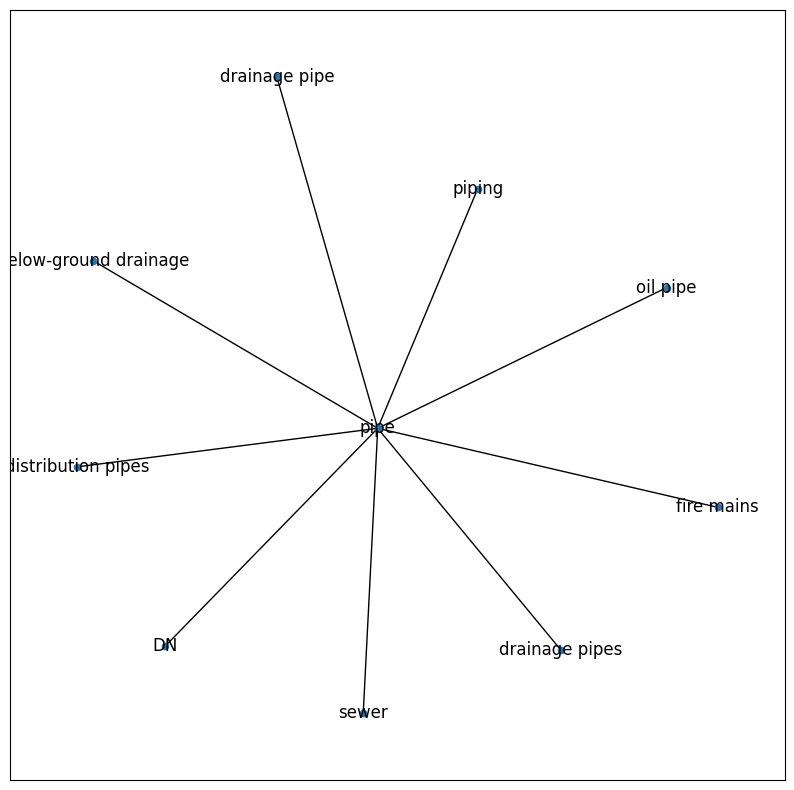

In [45]:
# node_of_interest = "photo-voltaic cell"
node_of_interest = 'drainage pipe'
focussed_graph = nx.ego_graph(network, node_of_interest, radius=10)
community_of_interest = divide_into_communities(focussed_graph, node_of_interest, max_community_size=50)

In [39]:
# This would compute all communities (dividing them down until they are under the maximum set size)
# divide_into_communities(network)
num_hops = 1
nodes_with_x_hops_distance = nx.single_source_shortest_path_length(network, node_of_interest, cutoff=num_hops)
nodes_with_x_hops_distance

{'vent': 0,
 'shaft': 1,
 'event': 1,
 'hose': 1,
 'inlet': 1,
 'ramp': 1,
 'cavity': 1}

In [131]:
node_of_interest = "wall"
focussed_graph = nx.ego_graph(network, node_of_interest, radius=1)

Community [4] of size 30, top 10 spans by degree:
0: building [149]
1: wall [107]
2: roof [71]
3: door [66]
4: pipe [55]
5: window [46]
6: beams [24]
7: sockets [22]
8: wall of [18]
9: defensive wall [18]


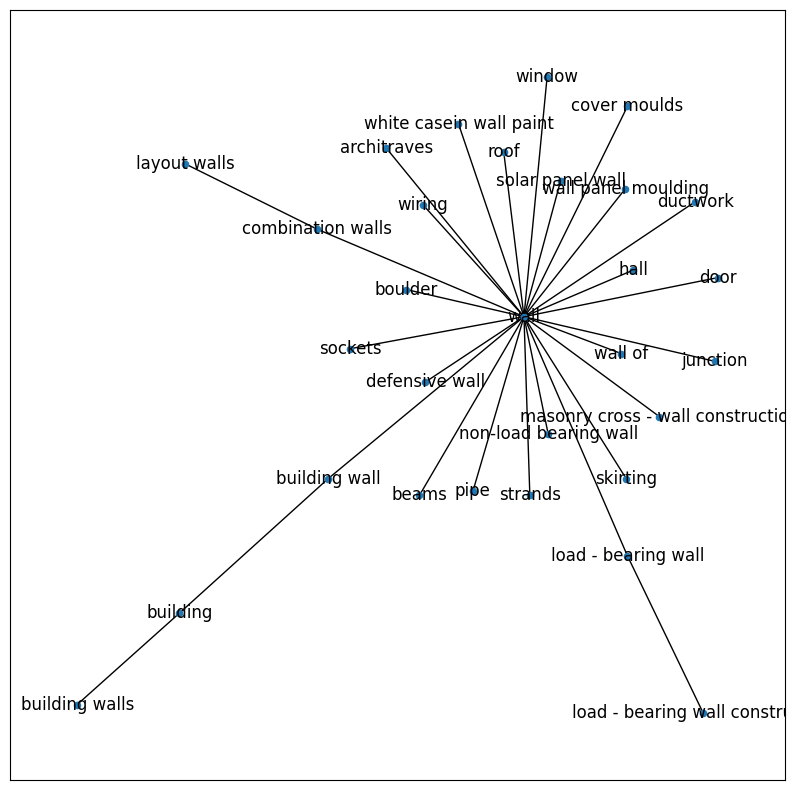

{'architraves',
 'beams',
 'boulder',
 'building',
 'building wall',
 'building walls',
 'combination walls',
 'cover moulds',
 'defensive wall',
 'door',
 'ductwork',
 'hall',
 'junction',
 'layout walls',
 'load - bearing wall',
 'load - bearing wall construction',
 'masonry cross - wall construction',
 'non-load bearing wall',
 'pipe',
 'roof',
 'skirting',
 'sockets',
 'solar panel wall',
 'strands',
 'wall',
 'wall of',
 'wall panel moulding',
 'white casein wall paint',
 'window',
 'wiring'}

In [132]:

divide_into_communities(focussed_graph, node_of_interest, max_community_size=100)

* Grab the definition for a term of interest; or one of the 'closely' related terms if the specific term is not defined

In [31]:
from collections import Counter

In [34]:
span_rel_cntr = Counter()
for k, v in distance_dict.items():
    related_spans = [str(t) for t in v]
    span_rel_cntr[k] = len(related_spans)
    

In [39]:
span_rel_cntr.most_common(10)

[('building', 155),
 ('Woodlands', 125),
 ('house', 112),
 ('water', 112),
 ('wall', 111),
 ('area', 105),
 ('floor', 102),
 ('room', 77),
 ('ventilation', 76),
 ('roof', 72)]

In [41]:
sorted(span_rel_cntr, key=span_rel_cntr.get, reverse=False)

['drywall',
 'vestibule',
 'Wards',
 'air conditioner',
 'birch',
 'bronze',
 'feldspar',
 'nanowatt',
 'newton',
 'registered third-party certifier',
 'titanium',
 'zinc',
 'cast iron',
 'turntable ladder',
 'alabaster',
 'brass',
 'decay',
 'ferrite',
 'gasket',
 'lumen',
 'ohm',
 'sandstone',
 'step-free',
 'ETFE',
 'Keys',
 'aisle',
 'cubic metre',
 'hertz',
 'clamp',
 'latch',
 'stainless steel',
 'tempered glass',
 'bamboo',
 'registered competent person',
 'hardwood',
 'vinyl',
 'architrave',
 'gram',
 'nickel',
 'onyx',
 'pissoir',
 'sash',
 'CAD/CAM',
 'glued laminated timber',
 'hopper',
 'kilometre',
 'litre',
 'basalt',
 'caulking',
 'gold',
 'lag screw',
 'reverberation',
 'solar cell panel',
 'steeply sloping plot',
 'strut',
 'asphalt shingle',
 'crystalline silicon',
 'fiber-reinforced concrete',
 'flame spread',
 'sex bolt',
 'helical stair',
 'private stair',
 'rain gutter',
 'spiral stair',
 'methane',
 'cogeneration',
 'insurance',
 'porch',
 'quartzite',
 'rw',
 'b

In [42]:
len([str(t) for t in distance_dict['vestibule']])

2

In [96]:
"""
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    prefix irec: <https://schema.irec.org/#>
    prefix skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?subject ?object
    WHERE {
        <SUBJECT> PREDICATE|^PREDICATE ?object_node .
        <SUBJECT> rdfs:label ?subject .
        ?object_node rdfs:label|skos:prefLabel ?object . 
    }
    """.replace("SUBJECT", str(test)).replace("PREDICATE", "irec:isSemanticallySimilarTo")

'\n    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>\n    prefix irec: <https://schema.irec.org/#>\n    prefix skos: <http://www.w3.org/2004/02/skos/core#>\n\n    SELECT DISTINCT ?subject ?object\n    WHERE {\n        <https://spans.irec.org/#amenity> irec:isSemanticallySimilarTo|^irec:isSemanticallySimilarTo ?object_node .\n        <https://spans.irec.org/#amenity> rdfs:label ?subject .\n        ?object_node rdfs:label|skos:prefLabel ?object . \n    }\n    '

In [10]:
# nearest neigbhours
neighbours = """
    OPTIONAL{
        SELECT DISTINCT ?nn where {
                ?s irec:isSemanticallySimilarTo|^irec:isSemanticallySimilarTo ?nn_node .
                ?nn_node rdfs:label ?nn .
            }
    }
"""

In [11]:
# count number of constitutes and morphological similarity relations
morphsim = """
    OPTIONAL{
        SELECT DISTINCT ?sim {
            ?s irec:isMorphologicallySimilarTo|^irec:isMorphologicallySimilarTo ?m_node .
            ?m_node rdfs:label ?sim .
            }
    }
"""

In [ ]:
# candidate alternative labels (overlap of morphsim and semantically similar, plus any acronyms)
alternative_labels = f"""
    \{ 
        SELECT ?span WHERE \{ 
        \{ {neighbours} \}
        UNION  
        \{ {morphsim} \}
        # also acronyms
        ?s irec:hasAcronym ?acronym_node .
        ?acronym_node rdfs:label ?span .
    \}
"""

In [ ]:
# grab the spans this span constitutes (superclass) and the reverse (subclasses)
constitutes = """
    OPTIONAL{
        select ?s (group_concat(?mc;separator=";\n") as ?mcs)
                  (count(?mc) as ?mcCount) where {
            ?s irec:constitutes|^irec:constitutes ?mc_node .
            ?mc_node rdfs:label ?mc .
            } group by ?s 
    }
"""

In [29]:
# grab any related objects
related = """
    OPTIONAL{
        ?s (irec:related|^irec:related) ?relatedUID .
        ?relatedUID rdfs:label ?relatedSpan .
        VALUES (?relatedUID) {(UNDEF)} 
    }
"""

In [30]:
# grab wikiClassLabels, if the node has any
wiki_class_labels = """
    { select ?wikiClassUID ?wikiClassSpan  where {
            ?s a ?wikiClassUID.
            ?wikiClassUID rdfs:label ?wikiClassSpan .
            FILTER(?wikiClassUID != irec:CharacterSpan)
            VALUES (?wikiClassSpan) {(UNDEF)} 
        }
    }

"""

In [31]:
## grab definitions, if the node has one
definition_relations = """
   { 
        SELECT ?s ?span ?defSpanUID ?defSpan (count(?defSpan) as ?defCount) WHERE { 
            ?s a irec:CharacterSpan ;
               rdfs:label ?span ;
               irec:definitionRelation|^irec:definitionRelation ?defSpanUID .
            ?defSpanUID rdfs:label ?defSpan .
            VALUES (?defSpanUID) {(UNDEF)} 
        } GROUPBY ?s ?span ?defSpanUID ?defSpan HAVING (?defCount > 0) 
    }
"""

In [35]:
# compose the above into a single query
complete_query = f"""
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>


construct {{
    ?s rdfs:label ?span ;
       irec:definitionRelation ?defSpanUID ;
       rdf:type  ?wikiClassUID ;
       skos:related ?relatedUID ;
       irec:isSemanticallySimilarTo  ?nnSpanUID ;
       irec:isMorphologicallySimilarTo  ?morphSpanUID ;
       irec:constitutes  ?constSpanUID ;
       irec:hasAcronym  ?acronymUID .
    
    ?defSpanUID rdfs:label ?defSpan . 
    ?wikiClassUID  rdfs:label ?wikiClassSpan . 
    ?relatedUID rdfs:label relatedSpan .
    ?nnSpanUID rdfs:label ?defSpan . 
    ?morphSpanUID  rdfs:label ?wikiClassSpan . 
    ?constSpanUid rdfs:label ?defSpan . 
    ?acronymUID  rdfs:label ?acronymSpan . 

}}
where {{
    # 1st identify all the CharacterSpan nodes and their labels (disregard efficiency, as graph is small)
    #     as long as they have at least 1 definition relation to another span.
    {definition_relations}
    
    # 2nd identify all the wikiclasses for the span;
    {wiki_class_labels}
    
    # 3rd identify the related spans, if they exist;
    {related}
    
    #4th 
    
}}  
"""


In [34]:
print(complete_query)


PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>


construct {
    ?s rdfs:label ?span ;
       irec:definitionRelation ?defSpanUID ;
       rdf:type  ?wikiClassUID ;
       skos:related ?relatedUID ;
       irec:isSemanticallySimilarTo  ?nnSpanUID ;
       irec:isMorphologicallySimilarTo  ?morphSpanUID ;
       irec:constitutes  ?constSpanUID ;
       irec:hasAcronym  ?acronymUID .
    
    ?defSpanUID rdfs:label ?defSpan . 
    ?wikiClassUID  rdfs:label ?wikiClassSpan . 
    ?relatedUID rdfs:label relatedSpan .
    ?nnSpanUID rdfs:label ?defSpan . 
    ?morphSpanUID  rdfs:label ?wikiClassSpan . 
    ?constSpanUid rdfs:label ?defSpan . 
    ?acronymUID  rdfs:label ?acronymSpan . 

}
where {
    # 1st identify all the span nodes and their labels (more efficient in different order, but graph is small)
    ?s rdfs:label ?span .
    
 

3947

90271

In [53]:
len(list(set(nodes_for_subgraph)))

17853

In [58]:
network = nx.subgraph(featured_nx_graph, list(set(nodes_for_subgraph)))

### Multiple paths; weighted graph
* We could store the subject node UID and object node UID separately. This may be useful when working with concepts in more detail. We don't really need this now, because for spans the UID is simply a coversion: `urllib.parse.quote('span')`

In [124]:
# REMOVE LIMIT FROM get_single_type_edges query; need to consider parallel execution here
distance_dict = {}
for edge_type, edge_weight in tqdm(zip(edge_types, edge_weights)):
    sparql_result = get_single_type_edges(irec_graph, edge_type)
    for r in sparql_result:
        if r.subject != r.object:
            subj = str(r.subject)
            obj = str(r.object)
            # figure out weights (will be distances in the graph actually, so high value is less related)
            if subj not in distance_dict:
                distance_dict[subj] = {obj : maximum_distance - edge_weight}
            else:
                if obj not in distance_dict[subj]:
                    distance_dict[subj][obj] = maximum_distance - edge_weight
                else:
                    distance_dict[subj][obj] -= edge_weight

8it [00:18,  2.32s/it]


In [125]:
network = nx.Graph()
network.add_weighted_edges_from([(s, o, w) for s, r in distance_dict.items() for o, w in r.items()])

In [ ]:
# mst = nx.minimum_spanning_tree(network)

In [ ]:
# plt.figure(figsize=(10, 10))
# nx.draw_networkx(mst, with_labels=True, node_size = 20)
# plt.show()

In [59]:
def show_community(idx: Union[str, int], community: set, network: nx.Graph = network):
    print(f"Community [{idx}] of size {len(community)}, top 10 spans by degree:")
    span_degree_dict = dict(network.degree(g for g in community))
    spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
    for idx, span_nedges in enumerate(spans_sorted_by_num_edges[:10]):
        span_node, num_edges = span_nedges
        [print(f"{idx}: {s_triple[2]} [{num_edges}]") for s_triple in irec_graph.triples((None, RDFS.label, Literal(span_node, lang='en')))]

    mst = nx.minimum_spanning_tree(network.subgraph(community))
    plt.figure(figsize=(10, 10))
    nx.draw_networkx(mst, with_labels=True, node_size = 20)
    plt.show()

In [60]:
def divide_into_communities(network: nx.Graph, existing_community: set = None, existing_community_idx: str = None):
    # divide the network into communities
    louvain = nx.algorithms.community.louvain.louvain_communities(network)
       
    for idx, community in enumerate(louvain):
            
#         if not "party wall" in community:
#             continue
        
        new_idx = f"{existing_community_idx}.{idx}" if existing_community_idx else str(idx)
            
        if len(community) > 50: # max size of community
#             print(f"Community [{new_idx}] of size {len(community)} will be split further")
            divide_into_communities(network.subgraph(community), 
                                    existing_community=community, 
                                    existing_community_idx=new_idx)
        else:
            show_community(idx, community)
    
    

In [50]:
# divide_into_communities(network)

In [51]:
# ### TODO; pick a node in the graph and all of the nodes at distance X, then compute the communities
# #  I don't think the radius works
# divide_into_communities(nx.ego_graph(network, "drainage", radius=1))

In [52]:
# ### AIM; pick a node in the graph and all of the nodes at path_length X, then compute the communities
# # I think Louvain results in something else each time
# max_path_steps = 3
# nodes = set(nx.single_source_shortest_path_length(network, "party wall", cutoff=max_path_steps).keys())
# subgraph = network.subgraph(nodes)
# divide_into_communities(subgraph)

In [53]:
# ### AIM; pick a node in the graph and all of the nodes at path_length X, then compute the communities
# # different result each time
# max_path_weight = 1 * maximum_distance
# nodes = set(nx.single_source_dijkstra_path(network, "material", cutoff=max_path_weight).keys())
# subgraph = network.subgraph(nodes)
# divide_into_communities(subgraph)


In [ ]:
# L = nx.laplacian_matrix(G)

### SPARQL identification of directly related spans

In [43]:
# Single term query 
user_query = 'party wall'
test_query = """
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix irec: <https://schema.irec.org/#>

SELECT ?other_label
WHERE {
    ?a irec:related|^irec:related|^irec:definitionRelation|irec:definitionRelation|irec:constitutes|^irec:constitutes ?b . 
    ?b rdfs:label ?other_label .
    ?a rdfs:label ?value .
    FILTER (CONTAINS(LCASE(str(?value)), "QUERY"))
}
""".replace('QUERY', user_query)

In [44]:
res = irec_graph.query(test_query)    

In [47]:
len([(Literal(user_query, lang='en'), r.other_label) for r in res if r.other_label != Literal(user_query)])

16

In [48]:
# trying to direclty create the graph from the sparql result
start = time()
impact_graph = nx.Graph()
impact_graph.add_weighted_edges_from([(Literal(user_query, lang='en'), r.other_label, {'weight': 1}) for r in res if r.other_label != Literal(user_query)])
print(f"took {time()-start} seconds")

took 0.0004999637603759766 seconds


In [49]:
# For now we'll separate the creation of the edgelist, rather than creating the graph directly
start = time()
edge_list = []
weight_list = []
for row in res:
    if Literal(user_query) != row.other_label:
        edge_list.append((Literal(user_query), row.other_label, {"weight": 1}))
impact_graph = nx.Graph()
impact_graph.add_weighted_edges_from(edge_list)
print(f"took {time()-start} seconds")

took 0.0006792545318603516 seconds


In [50]:
print(f"Number of edges related to `{user_query}`: {len(edge_list)}")

Number of edges related to `party wall`: 16


In [51]:
span_degree_dict = dict(UG.degree((g for g in impact_graph.nodes())))
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]

Top 20 spans by degree:
1: residence [3]
2: notional boundary [2]
3: framed wall [2]
4: adjoining dwelling [1]
5: building owner [1]
6: moeity [1]
7: buildings [1]
8: dividing partition [1]
9: tenants [1]
10: units [1]
11: walls [1]


In [80]:
test_graph = nx.Graph()
for t in edge_list:
    test_graph.add_edge(t[0], t[1])

In [ ]:
mst = nx.minimum_spanning_tree(test_graph)

In [54]:
# plt.figure(figsize=(10, 10))
# # nx.draw_networkx(mst, with_labels=True, node_size = 20)
# plt.show()

### SPARQL identification of terms meeting minimum requirements
* span has a wikidata definition 
* if span contains an antonym, is there a morphologically similar span with the antonym
* wikiclass
* domain-classification 


In [84]:
# All constitutes relations
test_query = """
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX irec: <https://schema.irec.org/#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
select ?span ?definition ?related ?related_node_def  where { 
	# grab the span of interest
	?s rdfs:label ?span .
    FILTER (LCASE(str(?span))="party wall"||LCASE(str(?span))="party walls")
    # grab definition, if the node has one
    OPTIONAL{
        ?s irec:exactMatch/skos:definition|irec:wikiDefinition ?definition .
    }
    # grab any related objects
    OPTIONAL{
        ?s irec:related|^irec:related|irec:definitionRelation|^irec:definitionRelation ?o .
        ?o rdfs:label ?related .
        # grab definition, if the node has one
        OPTIONAL{
            ?o irec:exactMatch/skos:definition|irec:wikiDefinition ?related_node_def .
        }
        }
} limit 100 

"""
res = irec_graph.query(test_query)

In [85]:
for row in res:
    print(row)

(rdflib.term.Literal('Party walls', lang='en'), None, None, None)
(rdflib.term.Literal('party walls', lang='en'), None, None, None)
(rdflib.term.Literal('party wall', lang='en'), rdflib.term.Literal('dividing partition between two adjoining buildings (or units) that is shared by the tenants of each residence', lang='en'), rdflib.term.Literal('adjoining dwelling', lang='en'), None)
(rdflib.term.Literal('party wall', lang='en'), rdflib.term.Literal('dividing partition between two adjoining buildings (or units) that is shared by the tenants of each residence', lang='en'), rdflib.term.Literal('building owner', lang='en'), None)
(rdflib.term.Literal('party wall', lang='en'), rdflib.term.Literal('dividing partition between two adjoining buildings (or units) that is shared by the tenants of each residence', lang='en'), rdflib.term.Literal('moeity', lang='en'), None)
(rdflib.term.Literal('party wall', lang='en'), rdflib.term.Literal('dividing partition between two adjoining buildings (or units

### All relations of a type

In [17]:
for row in res:
    print(row)

(rdflib.term.Literal('absorption coefficient', lang='en'), rdflib.term.Literal('absorption coefficient', lang='en'))
(rdflib.term.Literal('electrical installation', lang='en'), rdflib.term.Literal('electrical installation', lang='en'))
(rdflib.term.Literal('flat', lang='en'), rdflib.term.Literal('flat', lang='en'))
(rdflib.term.Literal('flight', lang='en'), rdflib.term.Literal('flight', lang='en'))
(rdflib.term.Literal('floating floor', lang='en'), rdflib.term.Literal('floating floor', lang='en'))
(rdflib.term.Literal('frequency', lang='en'), rdflib.term.Literal('frequency', lang='en'))
(rdflib.term.Literal('frequency band', lang='en'), rdflib.term.Literal('frequency band', lang='en'))
(rdflib.term.Literal('gallery', lang='en'), rdflib.term.Literal('gallery', lang='en'))
(rdflib.term.Literal('greywater', lang='en'), rdflib.term.Literal('greywater', lang='en'))
(rdflib.term.Literal('handrail', lang='en'), rdflib.term.Literal('handrail', lang='en'))
(rdflib.term.Literal('infiltration', l

(rdflib.term.Literal('Explosives', lang='en'), rdflib.term.Literal('Explosives', lang='en'))
(rdflib.term.Literal('External lighting systems', lang='en'), rdflib.term.Literal('External lighting systems', lang='en'))
(rdflib.term.Literal('External ramps', lang='en'), rdflib.term.Literal('External ramps', lang='en'))
(rdflib.term.Literal('Fans', lang='en'), rdflib.term.Literal('Fans', lang='en'))
(rdflib.term.Literal('Fire alarm sounders', lang='en'), rdflib.term.Literal('Fire alarm sounders', lang='en'))
(rdflib.term.Literal('Fire compartments', lang='en'), rdflib.term.Literal('Fire compartments', lang='en'))
(rdflib.term.Literal('Fire doorsets', lang='en'), rdflib.term.Literal('Fire doorsets', lang='en'))
(rdflib.term.Literal('Fire engineer', lang='en'), rdflib.term.Literal('Fire engineer', lang='en'))
(rdflib.term.Literal('Fire safety strategy', lang='en'), rdflib.term.Literal('Fire safety strategy', lang='en'))
(rdflib.term.Literal('Fireplace surrounds', lang='en'), rdflib.term.Liter

(rdflib.term.Literal('Reception desks', lang='en'), rdflib.term.Literal('Reception desks', lang='en'))
(rdflib.term.Literal('Reference', lang='en'), rdflib.term.Literal('Reference', lang='en'))
(rdflib.term.Literal('Refrigeration', lang='en'), rdflib.term.Literal('Refrigeration', lang='en'))
(rdflib.term.Literal('Reinforcement', lang='en'), rdflib.term.Literal('Reinforcement', lang='en'))
(rdflib.term.Literal('Repair', lang='en'), rdflib.term.Literal('Repair', lang='en'))
(rdflib.term.Literal('Reservoirs', lang='en'), rdflib.term.Literal('Reservoirs', lang='en'))
(rdflib.term.Literal('Resilient bars', lang='en'), rdflib.term.Literal('Resilient bars', lang='en'))
(rdflib.term.Literal('Resilient layer insulation', lang='en'), rdflib.term.Literal('Resilient layer insulation', lang='en'))
(rdflib.term.Literal('Retail parks', lang='en'), rdflib.term.Literal('Retail parks', lang='en'))
(rdflib.term.Literal('Revisions', lang='en'), rdflib.term.Literal('Revisions', lang='en'))
(rdflib.term.Lit

(rdflib.term.Literal('assembly', lang='en'), rdflib.term.Literal('assembly', lang='en'))
(rdflib.term.Literal('assembly hall', lang='en'), rdflib.term.Literal('assembly hall', lang='en'))
(rdflib.term.Literal('audience', lang='en'), rdflib.term.Literal('audience', lang='en'))
(rdflib.term.Literal('audio', lang='en'), rdflib.term.Literal('audio', lang='en'))
(rdflib.term.Literal('automatic door', lang='en'), rdflib.term.Literal('automatic door', lang='en'))
(rdflib.term.Literal('baths', lang='en'), rdflib.term.Literal('Baths', lang='en'))
(rdflib.term.Literal('battery room', lang='en'), rdflib.term.Literal('battery room', lang='en'))
(rdflib.term.Literal('biomass', lang='en'), rdflib.term.Literal('biomass', lang='en'))
(rdflib.term.Literal('boarding house', lang='en'), rdflib.term.Literal('boarding house', lang='en'))
(rdflib.term.Literal('boiler rooms', lang='en'), rdflib.term.Literal('Boiler rooms', lang='en'))
(rdflib.term.Literal('boundaries', lang='en'), rdflib.term.Literal('Bounda

(rdflib.term.Literal('note', lang='en'), rdflib.term.Literal('note', lang='en'))
(rdflib.term.Literal('office', lang='en'), rdflib.term.Literal('office', lang='en'))
(rdflib.term.Literal('office building', lang='en'), rdflib.term.Literal('office building', lang='en'))
(rdflib.term.Literal('ozone', lang='en'), rdflib.term.Literal('ozone', lang='en'))
(rdflib.term.Literal('painting', lang='en'), rdflib.term.Literal('Painting', lang='en'))
(rdflib.term.Literal('painting', lang='en'), rdflib.term.Literal('painting', lang='en'))
(rdflib.term.Literal('panel', lang='en'), rdflib.term.Literal('panel', lang='en'))
(rdflib.term.Literal('parapet', lang='en'), rdflib.term.Literal('parapet', lang='en'))
(rdflib.term.Literal('parasite', lang='en'), rdflib.term.Literal('parasite', lang='en'))
(rdflib.term.Literal('permeability', lang='en'), rdflib.term.Literal('permeability', lang='en'))
(rdflib.term.Literal('photocopiers', lang='en'), rdflib.term.Literal('Photocopiers', lang='en'))
(rdflib.term.Lite

(rdflib.term.Literal('HEPA', lang='en'), rdflib.term.Literal('HEPA', lang='en'))
(rdflib.term.Literal('LPG', lang='en'), rdflib.term.Literal('LPG', lang='en'))
(rdflib.term.Literal('Notes', lang='en'), rdflib.term.Literal('Notes', lang='en'))
(rdflib.term.Literal('Reading', lang='en'), rdflib.term.Literal('Reading', lang='en'))
(rdflib.term.Literal('absorbent', lang='en'), rdflib.term.Literal('absorbent', lang='en'))
(rdflib.term.Literal('accreditation', lang='en'), rdflib.term.Literal('accreditation', lang='en'))
(rdflib.term.Literal('activities', lang='en'), rdflib.term.Literal('Activities', lang='en'))
(rdflib.term.Literal('adsorbent', lang='en'), rdflib.term.Literal('adsorbent', lang='en'))
(rdflib.term.Literal('aisle', lang='en'), rdflib.term.Literal('aisle', lang='en'))
(rdflib.term.Literal('alabaster', lang='en'), rdflib.term.Literal('alabaster', lang='en'))
(rdflib.term.Literal('alternating tread stairs', lang='en'), rdflib.term.Literal('alternating tread stairs', lang='en'))
(

(rdflib.term.Literal('gigawatt', lang='en'), rdflib.term.Literal('gigawatt', lang='en'))
(rdflib.term.Literal('glass wool', lang='en'), rdflib.term.Literal('glass wool', lang='en'))
(rdflib.term.Literal('glue', lang='en'), rdflib.term.Literal('glue', lang='en'))
(rdflib.term.Literal('gold', lang='en'), rdflib.term.Literal('gold', lang='en'))
(rdflib.term.Literal('gram', lang='en'), rdflib.term.Literal('gram', lang='en'))
(rdflib.term.Literal('granite', lang='en'), rdflib.term.Literal('granite', lang='en'))
(rdflib.term.Literal('green', lang='en'), rdflib.term.Literal('green', lang='en'))
(rdflib.term.Literal('green roof', lang='en'), rdflib.term.Literal('green roof', lang='en'))
(rdflib.term.Literal('greenhouse gas', lang='en'), rdflib.term.Literal('greenhouse gas', lang='en'))
(rdflib.term.Literal('gross', lang='en'), rdflib.term.Literal('gross', lang='en'))
(rdflib.term.Literal('handmade', lang='en'), rdflib.term.Literal('handmade', lang='en'))
(rdflib.term.Literal('harmonic', lang='

(rdflib.term.Literal('preventive maintenance', lang='en'), rdflib.term.Literal('preventive maintenance', lang='en'))
(rdflib.term.Literal('printing', lang='en'), rdflib.term.Literal('Printing', lang='en'))
(rdflib.term.Literal('privacy', lang='en'), rdflib.term.Literal('privacy', lang='en'))
(rdflib.term.Literal('protected area', lang='en'), rdflib.term.Literal('protected area', lang='en'))
(rdflib.term.Literal('quartzite', lang='en'), rdflib.term.Literal('quartzite', lang='en'))
(rdflib.term.Literal('realistic', lang='en'), rdflib.term.Literal('realistic', lang='en'))
(rdflib.term.Literal('recorded', lang='en'), rdflib.term.Literal('recorded', lang='en'))
(rdflib.term.Literal('redwood', lang='en'), rdflib.term.Literal('redwood', lang='en'))
(rdflib.term.Literal('residential buildings', lang='en'), rdflib.term.Literal('Residential buildings', lang='en'))
(rdflib.term.Literal('revolving door', lang='en'), rdflib.term.Literal('revolving door', lang='en'))
(rdflib.term.Literal('ridge', la

(rdflib.term.Literal('doorway', lang='en'), rdflib.term.Literal('doorway', lang='en'))
(rdflib.term.Literal('dry', lang='en'), rdflib.term.Literal('dry', lang='en'))
(rdflib.term.Literal('electric current', lang='en'), rdflib.term.Literal('electric current', lang='en'))
(rdflib.term.Literal('electric power', lang='en'), rdflib.term.Literal('electric power', lang='en'))
(rdflib.term.Literal('electrical wiring', lang='en'), rdflib.term.Literal('electrical wiring', lang='en'))
(rdflib.term.Literal('engineered bamboo', lang='en'), rdflib.term.Literal('engineered bamboo', lang='en'))
(rdflib.term.Literal('exit', lang='en'), rdflib.term.Literal('exit', lang='en'))
(rdflib.term.Literal('finish', lang='en'), rdflib.term.Literal('finish', lang='en'))
(rdflib.term.Literal('first', lang='en'), rdflib.term.Literal('first', lang='en'))
(rdflib.term.Literal('fitting', lang='en'), rdflib.term.Literal('fitting', lang='en'))
(rdflib.term.Literal('flue', lang='en'), rdflib.term.Literal('flue', lang='en'

(rdflib.term.Literal('fire door', lang='en'), rdflib.term.Literal('fire door', lang='en'))
(rdflib.term.Literal('fireplace', lang='en'), rdflib.term.Literal('fireplace', lang='en'))
(rdflib.term.Literal('gypsum', lang='en'), rdflib.term.Literal('Gypsum', lang='en'))
(rdflib.term.Literal('gypsum', lang='en'), rdflib.term.Literal('gypsum', lang='en'))
(rdflib.term.Literal('hardwood', lang='en'), rdflib.term.Literal('hardwood', lang='en'))
(rdflib.term.Literal('hazard', lang='en'), rdflib.term.Literal('hazard', lang='en'))
(rdflib.term.Literal('limestone', lang='en'), rdflib.term.Literal('limestone', lang='en'))
(rdflib.term.Literal('lobby', lang='en'), rdflib.term.Literal('lobby', lang='en'))
(rdflib.term.Literal('lost', lang='en'), rdflib.term.Literal('lost', lang='en'))
(rdflib.term.Literal('magnesium', lang='en'), rdflib.term.Literal('magnesium', lang='en'))
(rdflib.term.Literal('metamorphic rock', lang='en'), rdflib.term.Literal('metamorphic rock', lang='en'))
(rdflib.term.Literal('m

(rdflib.term.Literal('house', lang='en'), rdflib.term.Literal('house', lang='en'))
(rdflib.term.Literal('light', lang='en'), rdflib.term.Literal('Light', lang='en'))
(rdflib.term.Literal('light', lang='en'), rdflib.term.Literal('light', lang='en'))
(rdflib.term.Literal('measurement', lang='en'), rdflib.term.Literal('measurement', lang='en'))
(rdflib.term.Literal('shower', lang='en'), rdflib.term.Literal('shower', lang='en'))
(rdflib.term.Literal('structural element', lang='en'), rdflib.term.Literal('structural element', lang='en'))
(rdflib.term.Literal('width', lang='en'), rdflib.term.Literal('width', lang='en'))
(rdflib.term.Literal('concrete', lang='en'), rdflib.term.Literal('concrete', lang='en'))
(rdflib.term.Literal('damp', lang='en'), rdflib.term.Literal('damp', lang='en'))
(rdflib.term.Literal('equipment', lang='en'), rdflib.term.Literal('Equipment', lang='en'))
(rdflib.term.Literal('extension', lang='en'), rdflib.term.Literal('extension', lang='en'))
(rdflib.term.Literal('fire 

In [8]:
# For now we'll separate the creation of the edgelist, rather than creating the graph directly
edge_list = []
for row in res:
    if row.aname != row.bname:
        edge_list.append([row.aname, row.bname])

KeyboardInterrupt: 

In [ ]:
edge_list[:10]

In [ ]:
constitutes_graph = nx.Graph()
constitutes_graph.add_edges_from(edge_list)

In [ ]:
# We're grouping terms together that form a network of overlapping words, e.g., (thermal resistance, resistance, fire resistance, fire, etc...)
louvain = nx.algorithms.community.louvain.louvain_communities(constitutes_graph)

In [ ]:
# For each group we're going to determine a minimum spanning tree, to identify prominent nodes (rather than degree)
span_degree_dict = {}
mst_list_dict = {}
for idx, community in enumerate(louvain):
    span_degree_dict[idx] = dict(constitutes_graph.degree((g for g in community)))
#     spans_sorted_by_num_edges = sorted(span_degree_dict[idx].items(), key=itemgetter(1), reverse=True)
#     for idx, span_node in enumerate(spans_sorted_by_num_edges[:20]):
#         [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]
    temp_graph = nx.Graph()
    for edge_list in [list(constitutes_graph.edges(node)) for node in community]:
        temp_graph.add_edges_from(edge_list)
    mst = nx.minimum_spanning_tree(temp_graph)
    mst_list_dict[idx] = sorted(mst.edges(data=True))


In [ ]:
print([k for k in span_degree_dict.keys() if len(span_degree_dict[k]) > 100])

In [ ]:
mst_list_dict[6]

In [ ]:
span_degree_dict = dict(G.degree((g for g in constitutes_graph.nodes())))

In [ ]:
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((None, RDFS.label, span_node[0]))]

### Identify Paths

### Connectedness

[{rdflib.term.Literal('Rainwater drainage systems', lang='en'),
  rdflib.term.Literal('metal', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#museum'),
  rdflib.term.URIRef('https://spans.irec.org/#the%20manufacturer'),
  rdflib.term.Literal('gradients', lang='en'),
  rdflib.term.Literal('a subject knowledge', lang='en'),
  rdflib.term.Literal('balcony', lang='en'),
  rdflib.term.Literal('tonal', lang='en'),
  rdflib.term.Literal('simplest organic molecule with one carbon atom and four hydrogen', lang='en'),
  rdflib.term.Literal('disadvantageous', lang='en'),
  rdflib.term.Literal('unable', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#an%20accessible%20bathroom'),
  rdflib.term.Literal('BS EN 1996 - 2', lang='en'),
  rdflib.term.Literal('hinge', lang='en'),
  rdflib.term.URIRef('https://spans.irec.org/#Tanneries'),
  rdflib.term.URIRef('https://spans.irec.org/#unrestrained'),
  rdflib.term.Literal('resilience', lang='en'),
  rdflib.term.URIRef('https://spans.ir

In [11]:
span_degree_dict = dict(G.degree((g for g in G.nodes() if str(g).startswith(IREC_spans_URL))))

In [12]:
spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 spans by degree:")
for idx, span_node in enumerate(spans_sorted_by_num_edges[1:21]):
    [print(f"{idx + 1}: {s_triple[2]} [{span_node[1]}]") for s_triple in irec_graph.triples((span_node[0], RDFS.label, None))]

Top 20 spans by degree:
1: house [229]
2: a building [103]
3: building [65]
4: water [61]
5: Hotel [55]
6: pipe [53]
7: Chimneys [50]
8: wall [48]
9: room [45]
10: area [45]
11: extension [44]
12: maintenance [43]
13: ceiling [42]
14: stone [41]
15: people [41]
16: ventilation [41]
17: material [41]
18: the building [40]
19: gallery [38]
20: fire doorset [38]


In [13]:
concept_degree_dict = dict(G.degree((g for g in G.nodes() if str(g).startswith(IREC_concepts_URL))))

In [14]:
concepts_sorted_by_num_edges = sorted(concept_degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 20 concepts by degree:")
for idx, d in enumerate(concepts_sorted_by_num_edges[:20]):
    # note that the list comprehension here exists for yielding from the generator
    # also the only reason we are skipping the schemeUID is because it doesn't have a prefLabel
    [print(f"{idx}: {c_triple[2]} [{d[1]}]") for c_triple in irec_graph.triples((d[0], SKOS.prefLabel, None))]

Top 20 concepts by degree:
1: fire doorset [36]
2: display window [34]
3: total useful floor area [33]
4: wet room [32]
5: key elements [31]
6: element of structure [31]
7: comité européen de normalisation [30]
8: commissioning [29]
9: unprotected area  [29]
10: specialist process lighting [27]
11: softened wholesome water [26]
12: dwelling [26]
13: unvented hot water storage system [26]
14: room [24]
15: external wall [24]
16: building [23]
17: pipe [23]
18: united kingdom accreditation service [23]
19: surface water activity [23]


### Node centrality

In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterized by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes (Wikipedia)

In [135]:
clustering = nx.clustering(network)
len(clustering)

6837

In [136]:
highly_connected_nodes = [n for n, clustering_coefficient in clustering.items() if clustering_coefficient < 0.1]

In [137]:
len(highly_connected_nodes)

1669

In [138]:
print("20 examples")
for idx, span_node in enumerate(highly_connected_nodes[:20]):
    [print(f"{idx}: {s_triple[2]}") for s_triple in irec_graph.triples((None, RDFS.label, Literal(span_node, lang='en')))]
    

20 examples
0: Air handling units
1: units
2: Fan coil units
3: Air conditioning units
4: air conditioning
5: Heat interface units
6: paving
7: unit
8: terminals
9: Calcium silicate blocks
10: blocks
11: glass
12: building
13: Buildings
14: buildings
15: Calcium silicate bricks
16: bricks
17: Clay
18: Demand for space
19: space


In [8]:
edge_types = [
    "irec:definitionRelation"
    "irec:constitutes",                    # exact word overlap
    "irec:isMorphologicallySimilarTo",     # similar words
    "irec:isSemanticallySimilarTo",        # similar contexts
    "irec:related",                        # manually grabbed from Approved documents indices
    "irec:hasAcronym",                     # acronyms are naive or index based, not very important 
    "irec:hasAntonym",                     # overlapping except for antonym
    "skos:related",                        # manually grabbed from Approved documents indices
    "skos:exactMatch"                      # the span has a concept with equivalent label
] 

In [13]:
edge_weights = [
    5,
    2,                    # exact word overlap
    1,                    # similar words
    1,                    # similar contexts
    10,                   # manually grabbed from Approved documents indices
    1,                    # acronyms are naive or index based, not very important 
    10,                 # overlapping except for antonym
    5,                    # manually grabbed from Approved documents indices
    10                    # the span has a concept with equivalent label
] 
maximum_distance = sum(edge_weights)

In [12]:
def get_single_type_edges(graph: Graph, edge_type: str = "irec:constitutes"):
    """
        We'll treate every edge as a bidirectional relation for now
    """
    test_query = """
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    prefix irec: <https://schema.irec.org/#>
    prefix skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?subject ?object
    WHERE {
        ?subject_node PREDICATE|^PREDICATE ?object_node .
        ?subject_node rdfs:label ?subject .
        ?object_node rdfs:label|skos:prefLabel ?object . 
    }
    LIMIT 25000
    """.replace("PREDICATE", edge_type)
    return irec_graph.query(test_query)

In [14]:
# REMOVE LIMIT FROM get_single_type_edges query; need to consider parallel execution here
distance_dict = {}
for edge_type, edge_weight in tqdm(zip(edge_types, edge_weights)):
    sparql_result = get_single_type_edges(irec_graph, edge_type)
    for r in sparql_result:
        if r.subject != r.object:
            subj = str(r.subject)
            obj = str(r.object)
            # figure out weights (will be distances in the graph actually, so high value is less related)
            if subj not in distance_dict:
                distance_dict[subj] = {obj : maximum_distance - edge_weight}
            else:
                if obj not in distance_dict[subj]:
                    distance_dict[subj][obj] = maximum_distance - edge_weight
                else:
                    distance_dict[subj][obj] -= edge_weight

8it [00:16,  2.00s/it]


In [15]:
network = nx.Graph()
network.add_weighted_edges_from([(str(s), str(o), w) for s, r in distance_dict.items() for o, w in r.items()])

In [16]:
def divide_into_communities(network: nx.Graph, 
                            node_of_interest: str = None,
                            max_community_size: int = 30,
                            existing_community: set = None, 
                            existing_community_idx: str = None):
    # divide the network into communities
    louvain = nx.algorithms.community.louvain.louvain_communities(network)
    community_of_interest = None
    for idx, community in enumerate(louvain):
        if node_of_interest:
            if not node_of_interest in community:
                continue
            else:
                community_of_interest = community
        
        new_idx = f"{existing_community_idx}.{idx}" if existing_community_idx else str(idx)
            
        if len(community) > max_community_size: # max size of community
            divide_into_communities(network.subgraph(community), 
                                    node_of_interest, max_community_size,
                                    existing_community=community, 
                                    existing_community_idx=new_idx)
        else:
            show_community(idx, community)
    
    return community_of_interest

In [135]:
def show_community(idx: Union[str, int], community: set, network: nx.Graph = network):
    print(f"Community [{idx}] of size {len(community)}, top 10 spans by degree:")
    span_degree_dict = dict(network.degree(g for g in community))
    spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
    for idx, span_nedges in enumerate(spans_sorted_by_num_edges[:10]):
        span_node, num_edges = span_nedges
        [print(f"{idx}: {s_triple[2]} [{num_edges}]") for s_triple in irec_graph.triples((None, RDFS.label, Literal(span_node, lang='en')))]

    mst = nx.minimum_spanning_tree(network.subgraph(community))
    plt.figure(figsize=(15, 10))
    nx.draw_networkx(mst, with_labels=True, node_size = 10)
    plt.show()
#     plt.savefig("plot.jpg", dpi=300, bbox_inches = "tight") #save as jpg

In [136]:
node_of_interest = "thermal insulation"

In [137]:
node_of_interest = "air conditioning"

In [144]:
node_of_interest = "acoustic insulation"

Community [3] of size 5, top 10 spans by degree:
0: acoustic insulation [8]
1: polyurethane insulation [8]
2: fire insulation [6]
3: mineral wool slab [4]
4: open-cell polyurethane insulation [2]


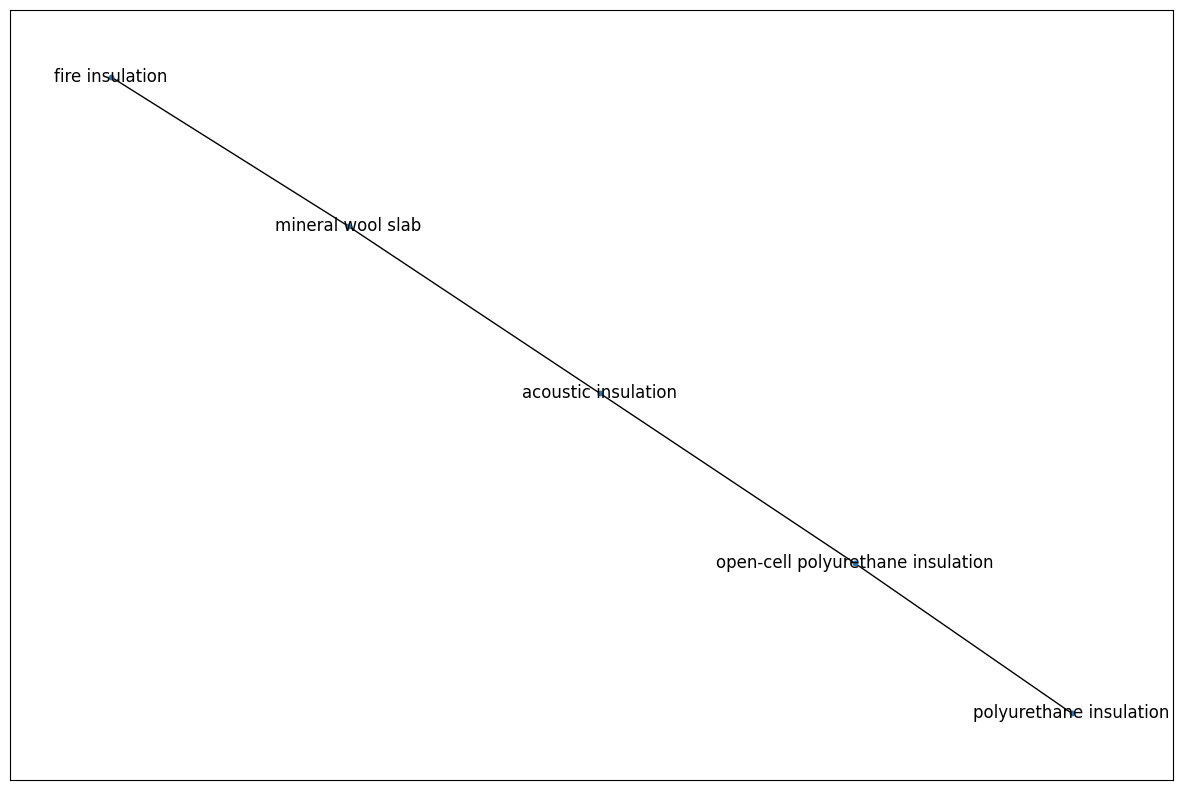

In [146]:
radius = 10
max_community = 15

focussed_graph = nx.ego_graph(network, node_of_interest, radius=radius)
community_of_interest = divide_into_communities(focussed_graph, node_of_interest, max_community_size=max_community)

# num_hops = 2
# nodes_with_x_hops_distance = nx.single_source_shortest_path_length(network, node_of_interest, cutoff=num_hops)
# nodes_with_x_hops_distance